训练自编码器

消融实验，直接在噪声数据上重构 轨迹


---

训练结果：



In [2]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T7PIAE5,T7DAE1,Vehicle_Model_Methods

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [3]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data

input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/data/Task2_data'  # 替换为你保存的.pkl文件路径
# 标准真值轨迹，标准噪声轨迹，标准化参数， 真值轨迹初值，噪声轨迹初值
tarin_data = load_preprocessed_data(os.path.join(input_file,'train_noisy_data.kpl'))

dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[3])
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)


val_data = load_preprocessed_data(os.path.join(input_file,'val_noisy_data.kpl'))

val_label = val_data[0].to(device)
val_input = val_data[1].to(device)
val_edge = val_data[3].to(device)


In [4]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [5]:

# 3. 定义模型、损失函数和优化器
#模型
model = T7PIAE5(torch.tensor(10),torch.tensor(0.25))
model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/good_models/20250320_Task5-1_T7PIAE5.pth', weights_only=True))
model.to(device)




# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': 1.0e-3}
    ]) # lr=0.001



In [ ]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/logs/log10')


# 4. 训练模型Autoencoder
epochs = 600

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (label,input,edge) in enumerate(dataloader):  
        # 添加噪声
        
        label = label.to(device)  # 将输入数据移动到同一设备
        input = input.to(device)


        feat = torch.diff(input,dim=1)

        # # 真值边界
        # edagepoint = edge[:,0:2,:]
        # endstate = edge[:,2,:]

        # 重构的
        edagepoint = torch.stack([input[:,0,:],input[:,-1,:]],dim=1)
        ve = torch.sqrt((input[:,-1,1]-input[:,-2,1])**2 +(input[:,-1,0]-input[:,-2,0])**2)/torch.tensor(0.1)
        phie = torch.arctan2(input[:,-1,1]-input[:,-2,1],input[:,-1,0]-input[:,-2,0])
        endstate = torch.stack([ve,phie],dim=1)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label, actions)

        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():

        val_feat = torch.diff(val_input,dim=1)

        # # 真值的
        # val_edagepoint = val_edge[:,0:2,:]
        # val_endstate = val_edge[:,2,:]
        # 重构的
        val_edagepoint = torch.stack([val_input[:,0,:],val_input[:,-1,:]],dim=1)
        val_ve = torch.sqrt((val_input[:,-1,1]-val_input[:,-2,1])**2 +(val_input[:,-1,0]-val_input[:,-2,0])**2)/torch.tensor(0.1)
        val_phie = torch.arctan2(val_input[:,-1,1]-val_input[:,-2,1],val_input[:,-1,0]-val_input[:,-2,0])
        val_endstate = torch.stack([val_ve,val_phie],dim=1)


        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
        orig_err = criterion(val_input, val_label)

    print(f'验证集上的指标为:{val_loss}，总噪声为:{orig_err},减少噪声{orig_err-val_loss}')
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task8_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task10_model_best.pth')
        best_loss = val_loss.item()


    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


验证集上的指标为:0.1729988008737564，总噪声为:0.025070490315556526,减少噪声-0.14792831242084503
Epoch 1, Train Loss: 0.1567983478307724, Val Loss: 0.1729988008737564
验证集上的指标为:0.13526202738285065，总噪声为:0.025070490315556526,减少噪声-0.11019153892993927
Epoch 2, Train Loss: 0.12467136234045029, Val Loss: 0.13526202738285065
验证集上的指标为:0.1150723472237587，总噪声为:0.025070490315556526,减少噪声-0.09000185877084732
Epoch 3, Train Loss: 0.0904797911643982, Val Loss: 0.1150723472237587
验证集上的指标为:0.10613564401865005，总噪声为:0.025070490315556526,减少噪声-0.08106515556573868
Epoch 4, Train Loss: 0.08368821442127228, Val Loss: 0.10613564401865005
验证集上的指标为:0.09627321362495422，总噪声为:0.025070490315556526,减少噪声-0.07120272517204285
Epoch 5, Train Loss: 0.08426348865032196, Val Loss: 0.09627321362495422
验证集上的指标为:0.09415551275014877，总噪声为:0.025070490315556526,减少噪声-0.0690850242972374
Epoch 6, Train Loss: 0.08451591432094574, Val Loss: 0.09415551275014877
验证集上的指标为:0.0906621515750885，总噪声为:0.025070490315556526,减少噪声-0.06559166312217712
Epoch 7, Train L

In [6]:

model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test7_final_together/model/trained_models/Task10_model_best.pth', weights_only=True))

model.eval()
with torch.no_grad():

    val_feat = torch.diff(val_input,dim=1)

    # # 真值的
    # val_edagepoint = val_edge[:,0:2,:]
    # val_endstate = val_edge[:,2,:]
    
    # 重构的
    val_edagepoint = torch.stack([val_input[:,0,:],val_input[:,-1,:]],dim=1)
    val_ve = torch.sqrt((val_input[:,-1,1]-val_input[:,-2,1])**2 +(val_input[:,-1,0]-val_input[:,-2,0])**2)/torch.tensor(0.1)
    val_phie = torch.arctan2(val_input[:,-1,1]-val_input[:,-2,1],val_input[:,-1,0]-val_input[:,-2,0])
    val_endstate = torch.stack([val_ve,val_phie],dim=1)

    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    orig_err = criterion(val_input, val_label)

print(f'验证集上的指标为:{val_loss}，总噪声为:{orig_err},减少噪声{orig_err-val_loss}')


验证集上的指标为:0.06743566691875458，总噪声为:0.025070490315556526,减少噪声-0.0423651784658432


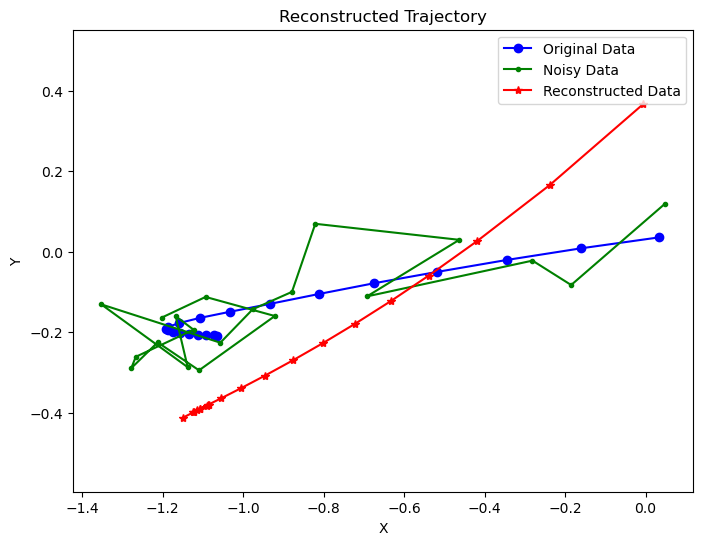

In [7]:
plt.figure(figsize=(8, 6))
# 绘制原始轨迹
import numpy as np
# num = 845
num = np.random.randint(0,30000)
num = 1025
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='Original Data')
plt.plot(val_input.cpu().numpy()[num, :,0], val_input.cpu().numpy()[num, :,1], '.-',c='g', label='Noisy Data')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '*-', c='red', label='Reconstructed Data')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()

In [15]:
# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err = self.ADE_err(out,labels)

        loss_err = loss_err.cpu().numpy()

        return out,loss_err

In [13]:
recon_tarj = Reconstruct_Traj()

out_one, err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

out_two, err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('两点重构误差',err_two_point)

单点单向重构误差 0.41312554
单点双向重构误差 0.20481035


In [16]:
# 计算突破约束比例

# 定义临时类
# 创建一个临时类并继承 MyMixin
class TempClass(Vehicle_Model_Methods):
    pass

# 实例化临时类
temp_instance = TempClass()
ax_out_rate,delta_out_rate,traj_out_rate=temp_instance.constrain_count(val_output,10,0.25)
print('加速度突破率：',ax_out_rate)
print('转向突破率：',delta_out_rate)
print('轨迹突破率：',traj_out_rate)

# delta1 = val_action[:,:,1]
# ax1 = val_action[:,:,0]
# delta1_out = torch.where((delta1 >= -0.25) & (delta1 <= 0.25), 0, 1)
# print(torch.sum(delta1_out).item())
# ax2,delta2 = temp_instance.calculate_action(val_output)
# delta2_out = torch.where((delta2 >= -0.25-0.001) & (delta2 <= 0.25+0.001), 0, 1)
# print(torch.sum(delta2_out).item())

# ns = torch.nonzero(delta2_out.sum(dim=1))
# n=ns[1]

# print(delta1[n,:])
# print(delta2[n,:])
# print(torch.max(delta1[n,:]-delta2[n,:]))
# print(torch.min(delta1[n,:]-delta2[n,:]))

# print(ax1[n,:])
# print(ax2[n,:])

加速度突破率： 0.0
转向突破率： 0.0
轨迹突破率： 0.0


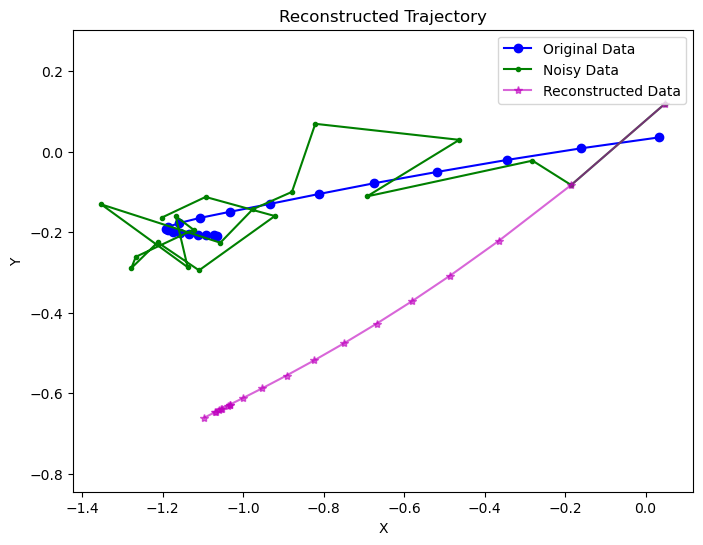

In [24]:
plt.figure(figsize=(8, 6))

num = 1025
# print(n)

plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='Original Data')
plt.plot(val_input.cpu().numpy()[num, :,0], val_input.cpu().numpy()[num, :,1], '.-',c='g', label='Noisy Data')
plt.plot(out_one.cpu().numpy()[num, :,0], out_one.cpu().numpy()[num, :,1], '*-', alpha=0.6,c='m', label='Reconstructed Data')
# plt.plot(out_two.cpu().numpy()[num, :,0], out_two.cpu().numpy()[num, :,1], '*-', c='red', label='Reconstructed Data out_two')
plt.title('Reconstructed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()